# Bibliotecas

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, ReLU, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.optimizers import RMSprop
from keras import initializers
from keras import backend as K

# Database MNIST

In [2]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


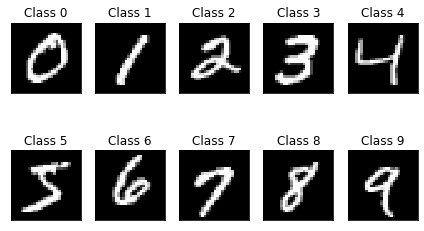

In [3]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

In [4]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


# Generator

In [5]:
#generator
# latent space dimension
latent_dim = 100

# imagem dimension 28x28x1
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC
generator.add(Dense(7*7*512, input_shape=(latent_dim,), kernel_initializer=init))
# generator.add(ReLU())
generator.add(Reshape((7, 7, 512)))

# # Conv 1
generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Conv 2
generator.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Output
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                              activation='tanh'))

In [6]:
# prints a summary representation of your model
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25088)             2533888   
                                                                 
 reshape (Reshape)           (None, 7, 7, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      589952    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       7

# Critic (Discriminator)

In [7]:
# Critic network
critic = Sequential()
# imagem shape 28x28x1
img_shape = X_train[0].shape
# Conv 1
critic.add(Conv2D(64, kernel_size=3, strides=2, padding='same',
                  input_shape=(img_shape)))
critic.add(LeakyReLU(0.2))
# Conv 2
critic.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))
# Conv 3
critic.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))
# Conv 4
critic.add(Conv2D(512, kernel_size=3, strides=1, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))
# FC
critic.add(Flatten())
# Output
critic.add(Dense(1))

In [ ]:
# summary of the model
critic.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                      

# Wasswestein 

In [8]:
# Wasserstein objective
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [9]:
# Following parameter and optimizer set as recommended in paper
n_critic = 5
clip_value = 0.01
optimizer = RMSprop(lr=0.00005)

critic.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


# WGAN(Generator+Critic)

In [10]:
critic.trainable = False

# The generator takes noise as input and generated imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# The critic takes generated images as input and determines validity
valid = critic(img)

# The combined model (critic and generative)
c_g = Model(inputs=z, outputs=valid, name='wgan')
c_g.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

In [11]:
# summary  of the model
c_g.summary()

Model: "wgan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         3198977   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1561601   
                                                                 
Total params: 4,760,578
Trainable params: 3,198,593
Non-trainable params: 1,561,985
_________________________________________________________________


# WGAN Training

epoch = 1/30, d_loss=-0.219, g_loss=0.466                                                                                                     


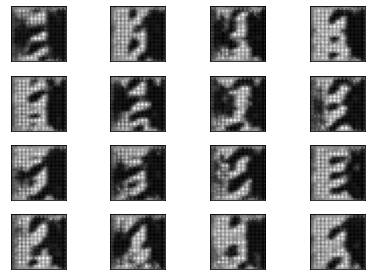

epoch = 2/30, d_loss=-0.036, g_loss=0.352                                                                                                     
epoch = 3/30, d_loss=-0.087, g_loss=0.326                                                                                                     
epoch = 4/30, d_loss=-0.158, g_loss=0.588                                                                                                     
epoch = 5/30, d_loss=-0.182, g_loss=0.590                                                                                                     
epoch = 6/30, d_loss=-0.207, g_loss=0.640                                                                                                     
epoch = 7/30, d_loss=-0.217, g_loss=0.567                                                                                                     
epoch = 8/30, d_loss=-0.196, g_loss=0.540                                                                                                     

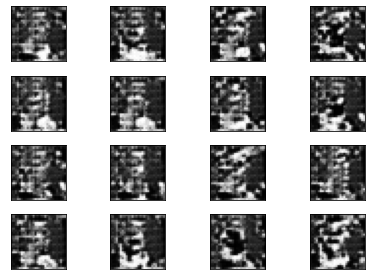

epoch = 12/30, d_loss=-0.196, g_loss=0.561                                                                                                     
epoch = 13/30, d_loss=-0.195, g_loss=0.566                                                                                                     
epoch = 14/30, d_loss=-0.200, g_loss=0.564                                                                                                     
epoch = 15/30, d_loss=-0.191, g_loss=0.550                                                                                                     
epoch = 16/30, d_loss=-0.190, g_loss=0.539                                                                                                     
epoch = 17/30, d_loss=-0.194, g_loss=0.545                                                                                                     
epoch = 18/30, d_loss=-0.185, g_loss=0.537                                                                                              

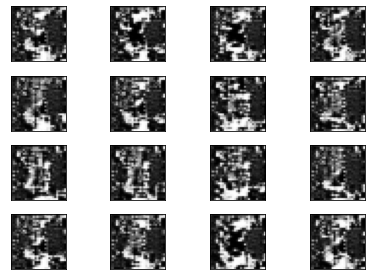

epoch = 22/30, d_loss=-0.206, g_loss=0.599                                                                                                     
epoch = 23/30, d_loss=-0.207, g_loss=0.603                                                                                                     
epoch = 24/30, d_loss=-0.209, g_loss=0.603                                                                                                     
epoch = 25/30, d_loss=-0.202, g_loss=0.591                                                                                                     
epoch = 26/30, d_loss=-0.207, g_loss=0.600                                                                                                     


In [ ]:
epochs = 30#100
batch_size = 32#64

real = -np.ones(shape=(batch_size, 1))
fake = np.ones(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        for _ in range(n_critic):

            # Train Discriminator weights
            critic.trainable = True

            # Real samples
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            d_loss_real = critic.train_on_batch(x=X_batch, y=real)

            # Fake Samples
            z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
            X_fake = generator.predict(z)
            d_loss_fake = critic.train_on_batch(x=X_fake, y=fake)

            # Discriminator loss
            d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

            # Clip critic weights
            for l in critic.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                l.set_weights(weights)

        # Train Generator weights
        critic.trainable = False
        g_loss_batch = c_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 16
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(4, 4, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()